# Lime for DNN Model

In [32]:
import pandas as pd
import os
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import cv2

In [33]:
# Define paths
photo_path = "C:/Users/indra/OneDrive - Loyalist College/Sem 3/CV/yelp_photos/photos"
photos_json_path = "C:/Users/indra/OneDrive - Loyalist College/Sem 3/CV/yelp_photos/photos.json" 

# Load JSON data 
photos_df = pd.read_json(photos_json_path, lines=True)

print(photos_df.head())

                 photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food  


In [34]:
model = load_model("model.h5")

In [35]:
#  Your class labels
class_names = ['drink', 'food', 'inside', 'menu', 'outside']

#  Preprocess for model
def preprocess_for_model(photo_id):
    path = os.path.join(photos_folder, f"{photo_id}.jpg")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return img.reshape(64, 64, 1)


In [36]:
# Preprocess for LIME (LIME needs RGB)
def preprocess_for_lime(photo_id):
    path = os.path.join(photos_folder, f"{photo_id}.jpg")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_rgb = np.stack([img] * 3, axis=-1)
    return img_rgb

In [37]:
#  LIME prediction wrapper
def predict_fn(images):
    images_gray = [cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0 for img in images]
    images_gray = np.array(images_gray).reshape(-1, 64, 64, 1)
    return model.predict(images_gray, verbose=0)

In [38]:
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

#  Pick one image per class
images_per_class = {}
for label in sorted(photos_df['label'].unique()):
    subset = photos_df[photos_df['label'] == label]
    for _, row in subset.iterrows():
        path = os.path.join(photos_folder, f"{row['photo_id']}.jpg")
        if os.path.exists(path):
            images_per_class[label] = row['photo_id']
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

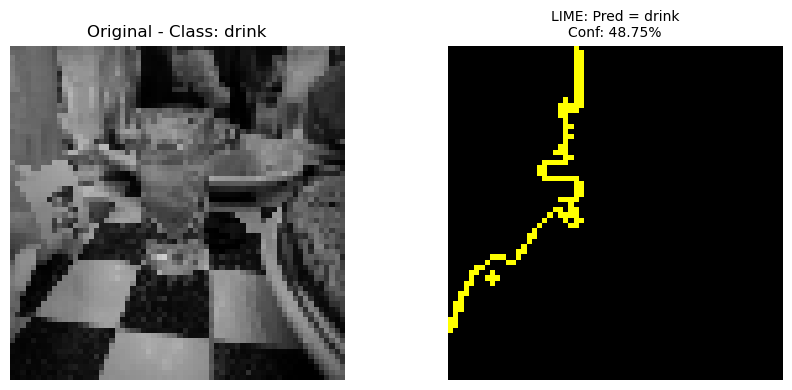

  0%|          | 0/1000 [00:00<?, ?it/s]

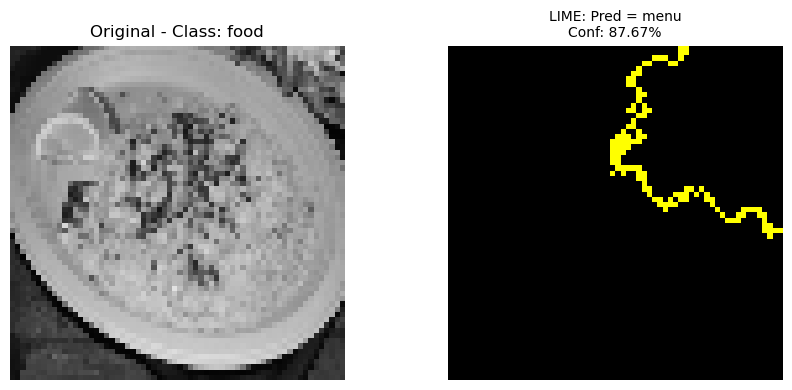

  0%|          | 0/1000 [00:00<?, ?it/s]

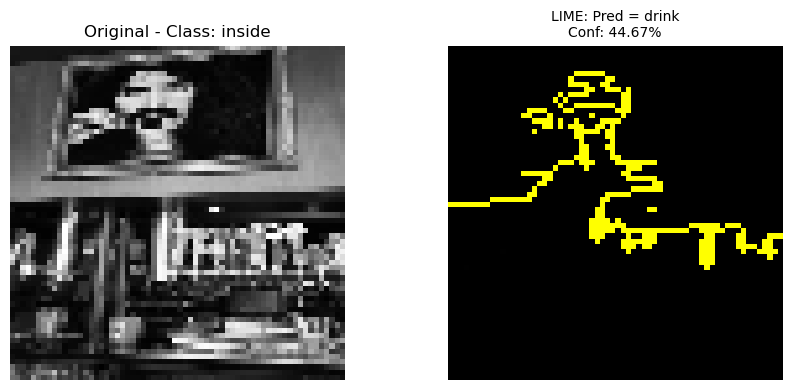

  0%|          | 0/1000 [00:00<?, ?it/s]

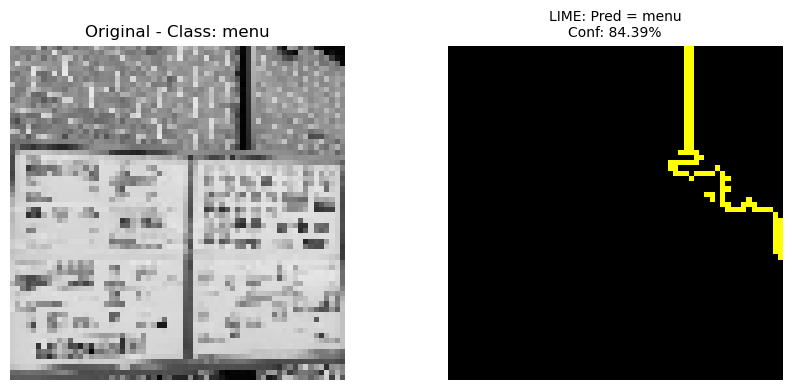

  0%|          | 0/1000 [00:00<?, ?it/s]

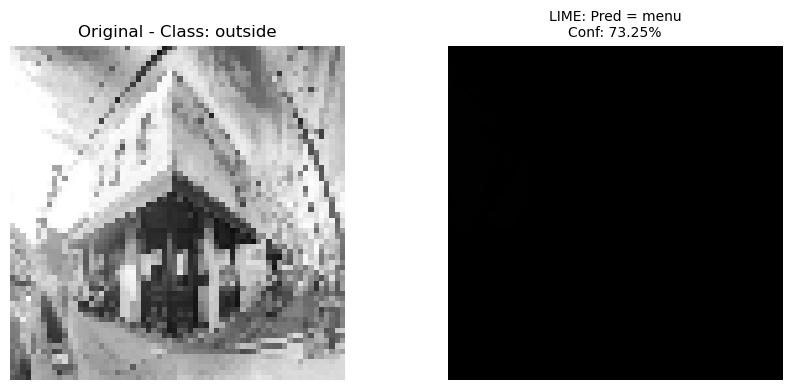

In [39]:
#  Run LIME per class
for label, photo_id in images_per_class.items():
    image = preprocess_for_lime(photo_id)

    # LIME explanation
    explanation = explainer.explain_instance(
        image.astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    #  Get prediction and confidence
    pred_probs = predict_fn([image])[0]
    pred_label_index = np.argmax(pred_probs)
    pred_confidence = pred_probs[pred_label_index] * 100
    pred_class_name = class_names[pred_label_index]

    #  Plot original and LIME output with prediction & confidence
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    axes[0].imshow(image)
    axes[0].set_title(f"Original - Class: {label}")
    axes[0].axis('off')

    axes[1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[1].set_title(f"LIME: Pred = {pred_class_name}\nConf: {pred_confidence:.2f}%", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [40]:
# Print top contributing regions for all classes
for label, photo_id in images_per_class.items():
    image = preprocess_for_lime(photo_id)

    explanation = explainer.explain_instance(
        image.astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    top_regions = explanation.local_exp[explanation.top_labels[0]]

    print(f"🟨 Class {label} — Photo ID: {photo_id}")
    print("Top contributing regions (feature index, weight):")
    print(top_regions)
    
    print("=" * 150)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class drink — Photo ID: vkr8T0scuJmGVvN2HJelEA
Top contributing regions (feature index, weight):
[(4, -0.08411309444628778), (2, -0.07500701854431559), (5, -0.07190287269575121), (1, -0.037210712743653764), (3, -0.03143475034302405), (0, 0.0009353216274479659)]


  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class food — Photo ID: pve7D6NUrafHW3EAORubyw
Top contributing regions (feature index, weight):
[(4, 0.4666142335287931), (3, 0.3457065286861531), (0, 0.12512757329427734), (2, -0.07124494602390861), (1, 0.005624971600069433)]


  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class inside — Photo ID: zsvj7vloL4L5jhYyPIuVwg
Top contributing regions (feature index, weight):
[(2, -0.3231054036970276), (1, 0.0612661876128444), (0, 0.025710189075300264)]


  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class menu — Photo ID: 6LJa8QZOGBjt9maE5miLhw
Top contributing regions (feature index, weight):
[(3, 0.45171163636146705), (2, 0.3610276418516801), (0, -0.11171527079087183), (1, 0.1006222194214147)]


  0%|          | 0/1000 [00:00<?, ?it/s]

🟨 Class outside — Photo ID: HCUdRJHHm_e0OCTlZetGLg
Top contributing regions (feature index, weight):
[(2, 0.28647964110317126), (3, 0.25061339548713213), (1, 0.19380124823307426), (0, 0.17069129951077858)]


# LIME Interpretation Summary for Image Classifier

---

### **Image 1 — Original Class: `drink`**
- **LIME Prediction**: `drink` with **48.75% confidence**
- **Insight**: **low confidence**, but **correct**
- **Top features (weights)**:
  - Most regions had **negative weights**, meaning they argued *against* the prediction.
  - Only feature 0 contributed positively: `(0, 0.0046)`
- **Interpretation**: The model was **uncertain** about this image being a drink. 

---

### **Image 2 — Original Class: `food`**
- **LIME Prediction**: `menu` with **87.67% confidence**
- **Insight**: Very **confident**, but **incorrect**.
- **Top features**:
  - Feature 4: `+0.464`
  - Feature 3: `+0.347`
  - Feature 0: `+0.132`
- **Interpretation**: Model likely misclassified the food as a menu

---

### **Image 3 — Original Class: `inside`**
- **LIME Prediction**: `drink` with **44.67% confidence**
- **Insight**: Model is **confused**. Image may include bottles or glasses that resemble drink-related visuals.
- **Top contributing regions**:
  - Feature 2: `-0.324` → strongly against the class
  - Feature 1 & 0: low positive influence
- **Interpretation**: Weak evidence supporting either class — the model is **not confident**.

---

### **Image 4 — Original Class: `menu`**
- **LIME Prediction**: `menu` with **84.39% confidence**
- **Correct** and **confident**.
- **Top contributing regions**:
  - Feature 3: `+0.451`
  - Feature 2: `+0.358`
  - Feature 1: `+0.103`
- **Interpretation**: Model correctly identified the image as a menu.

---

### **Image 5 — Original Class: `outside`**
- **LIME Prediction**: `menu` with **73.25% confidence**
- **Incorrect classification**
- **Observation**: LIME heatmap is mostly dark, indicating **low regional contribution**.
- **Interpretation**: Model may have misclassified due to structural patterns (e.g., signs, text) that mimic menu features.

---

### Summary Table

| Image | True Class | LIME Prediction | Confidence | Interpretation |
|-------|------------|------------------|-------------|----------------|
| 1     | drink      | drink            | 48.75%      | Low confidence, unclear support |
| 2     | food       | menu             | 87.67%      | Confident but wrong |
| 3     | inside     | drink            | 44.67%      | Confused, weak support |
| 4     | menu       | menu             | 84.39%      | Correct and confident |
| 5     | outside    | menu             | 73.25%      | Incorrect, weak region relevance |


## Lime Prompts for DNN Model

**1.** I have a deep learning model trained on grayscale images. How can I implement LIME?

**2.** Code to print top contributing regions for all classes.
